In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne
from sklearn.decomposition import PCA

Random with sampling rate =100 and a baseline time of 500ms

In [2]:
signal = np.random.uniform(0.0, 2.0, 2500*50)

# Split to trials
trials = np.array(np.array_split(signal, 50)) # (50, 40/20)

Real signal (P300 from MNE)

In [3]:
# df = pd.read_csv("p300-6trials-12rep-chaky.csv")

df = pd.read_csv("data_2017-02-04-16_03_08.csv")


from datetime import datetime

timestamp = 1545730073
timestampsArr = df["timestamps"].apply(datetime.fromtimestamp)
# 4 ms each step

df = df.drop(["timestamps", "TP9", "Right AUX"], axis=1)

#channels named according to how EEG is plugged
# channels = ['timestamps', 'P4', 'Pz', 'P3', 'PO4', 'POz', 'PO3', 'O2', 'O1', 'Marker']   
# df.columns = channels

channels = ["AF7","AF8","TP10", "Marker"]
df.columns = channels

# Marker
# 0: nothing happens
# 1: flash on non-target
# 2: flash on target

In [4]:
df.head()

,AF7,AF8,TP10,Marker
0,23.438,23.926,80.078,0
1,27.344,28.320,73.730,0
2,27.832,34.180,59.082,0
3,33.691,37.109,58.594,0
4,33.203,29.785,65.430,0


In [5]:
info = mne.create_info(ch_names = channels, sfreq = 100)
mneObj = mne.io.RawArray(df.transpose(), info)

Creating RawArray with float64 data, n_channels=4, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   307.310 secs
Ready.


In [6]:
events = mne.find_events(mneObj, stim_channel='Marker')
print('Number of events:', len(events))
print('Unique event codes:', np.unique(events[:, 2]))
event_id = dict(left=1, right=2)

195 events found
Event IDs: [1 2]
Number of events: 195
Unique event codes: [1 2]


In [7]:
# Trials
epochs = mne.Epochs(mneObj, events, event_id, preload=True)

Not setting metadata
195 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 195 events and 71 original time points ...
0 bad epochs dropped


In [8]:
epochs[0]._raw_times

array([-0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
       -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
       -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,
        0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,
        0.16,  0.17,  0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,
        0.25,  0.26,  0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,
        0.34,  0.35,  0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,
        0.43,  0.44,  0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ])

Using matplotlib as 2D backend.


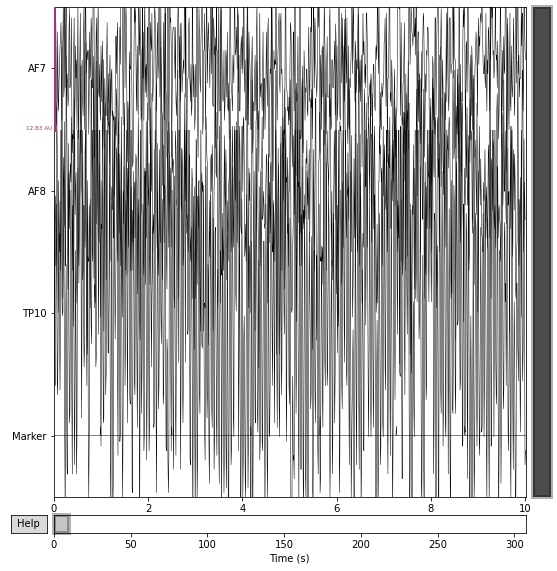

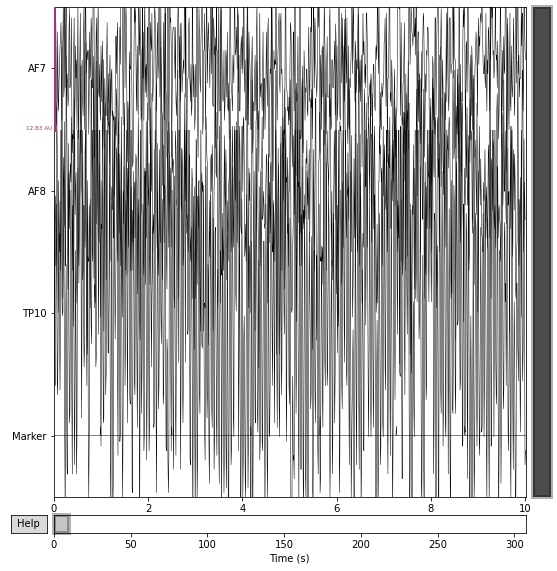

In [9]:
mneObj.plot()

In [10]:
# Applying PCA to reduce Dimensionality from 3 to 1 in each trial
real_trials = []
pca = PCA(n_components=1)
for i in range(len(epochs)):
   temp = np.array([epochs[i].get_data()[0][y] for y in range(3)])
   real_trials.append(pca.fit_transform(temp.T))
real_trials = np.array(real_trials).squeeze(-1)

In [11]:
def DFT(signal, fs):
    # reconstructing the waves using rotating vectors exploiting discrete signals harmonics feature
    N = len(signal)
    nyquist = fs/2
    coeff = []
    freq = np.array(list(range(0, N-1)))
    sine_t = np.linspace(0, N-1, N)/N

    # Generating different signals anf integrating 
    for i in range(N-1):
        sine_wave = np.exp(-2*np.pi*(1j)*freq[i]*sine_t)
        # print(signal.shape, sine_wave.shape)
        coeff.append(sine_wave@np.transpose(signal))  # integration
    
    coeff = np.array(coeff)
    coeff = coeff/ N

    # ptsHz = np.linspace(0,nyquist,(N/2)+1); 
    amp  = np.sqrt(coeff.real**2 + coeff.imag**2)*2
    phase = np.angle(coeff)
   
    return np.array(freq[:len(freq)//2]) , np.array(amp[:len(amp)//2]), phase

In [12]:
def plot_spectrogram(spec, trials, fs):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    # ks = np.linspace(0,spec.shape[0], 10)
    # freq_Hz = ks*fs/len(trials[0])
    # ksHz = [int(i) for i in freq_Hz] 
    # plt.yticks(ks,ksHz)
    # plt.ylabel("Frequency (Hz)")

    # ts_spec = np.linspace(0,spec.shape[1],1000)
    # ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,2*trials[0]/2,10)]
    # plt.xticks(np.arange(len(ks))/ 10, np.arange(len(ks))/10)
    plt.xlabel("Time (sec)")

    plt.colorbar(None,use_gridspec=True)
    plt.show()


Time Frequency Analysis

In [13]:
def tf(trials, windowSize = 100, overlapping = 50):
    new_trials = []
    percentage_changes = []
    for cnt, trial in enumerate(trials):
        # STFT
        temp = [DFT(trial[i : i + windowSize], 100)[1] for i in range(0, len(trial), overlapping)]
        temp = temp[:-2]
        # print(len(temp[0]))

        # Baseline Correction
        temp = np.array(temp)
        base_line = temp[:4]
        base_line_mean = np.mean(base_line, axis=1).reshape(-1, 1).T
        temp =  temp - base_line_mean
        
        # Percentage Change
        percentage_change = (temp/base_line_mean)*100
        percentage_changes.append(percentage_change)
        # print("Percentage Change: ", percentage_change)
        
        # Spectrogram
        temp = np.transpose(temp)
        if cnt == 0:
            plot_spectrogram(temp, trials, 100)
            plot_spectrogram(percentage_changes[0], trials, 100)

        new_trials.append(temp)
    return sum(new_trials)/len(new_trials), percentage_changes

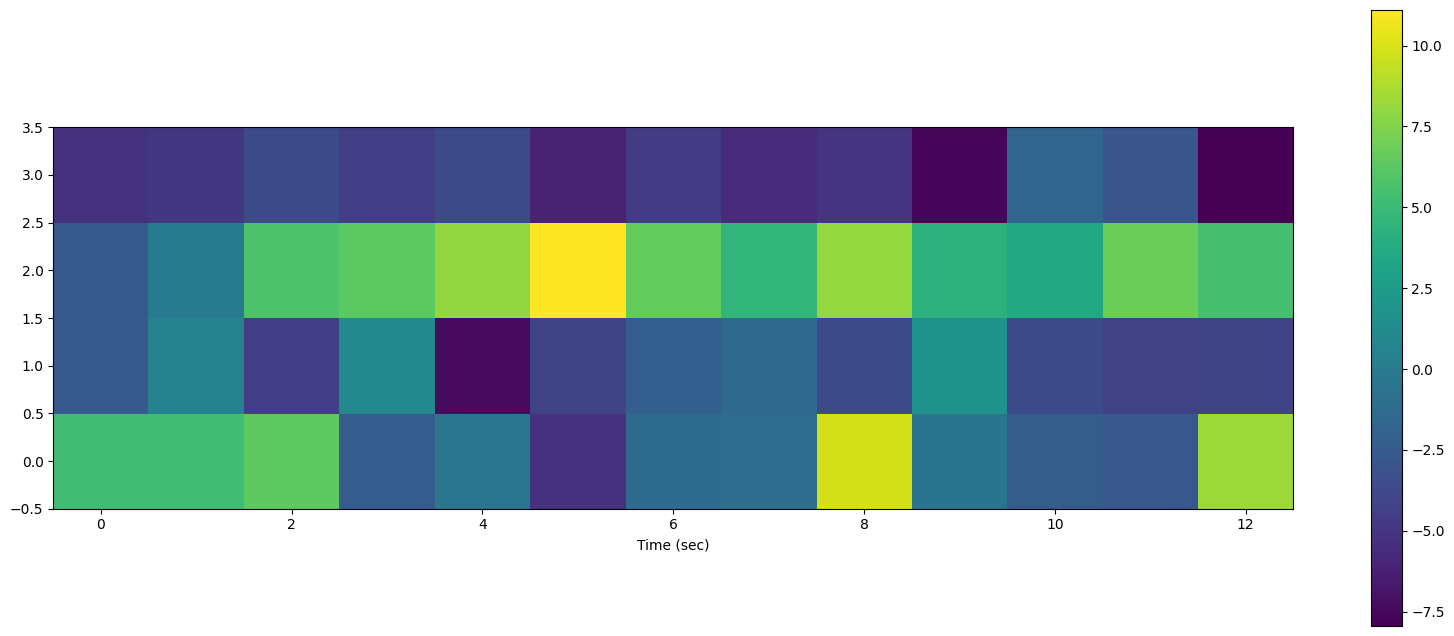

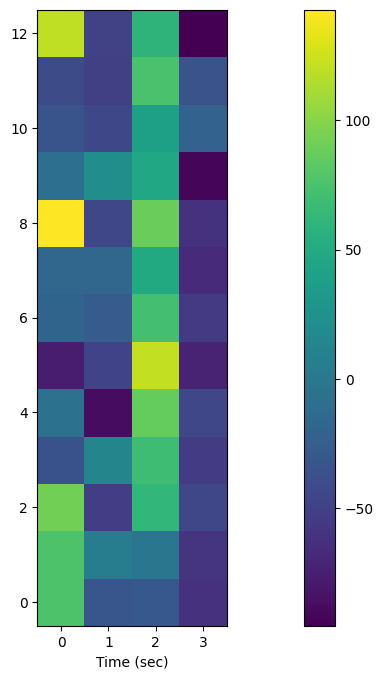

In [14]:
res, percentages_changes = tf(real_trials, 10,5)

Inter Trial Phase Consistency

In [15]:
def ITPC(trials, windowSize, overlapping):
    phases = []
    for cnt, trial in enumerate(trials):
        # Inter Trial Phase Consistency
        temp = [DFT(trial[i : i + windowSize], 100)[2] for i in range(0, len(trial), overlapping)]
        temp = temp[:-1]
        temp = np.transpose(temp)
        phases.append(temp)
    phases = np.array(phases)
    euler = [np.exp((1j)*phases[i]) for i in range(len(phases))]
    return euler  

In [17]:
res = ITPC(real_trials, 100, 50)

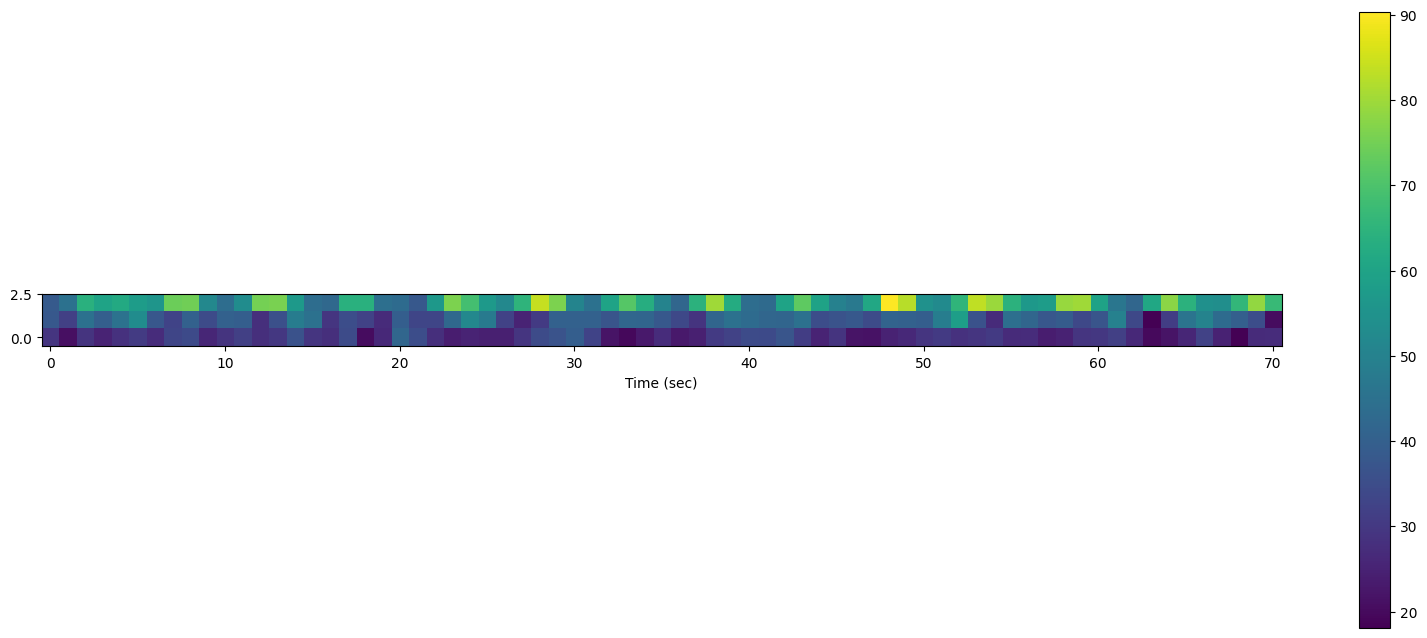

In [18]:
plot_spectrogram(temp, res, 100)